# Hands-on with catalogs stored in LSD (SDSS)

### Preambule

Remember to always set the `NWORKERS`, `LSD_CACHEDIR`, and `LSD_TEMPDIR` environmental variables when using LSD on magneto. Bad things can happen otherwise (you can bring down the whole machine)!

### Querying SDSS with LSD

Let's begin with importing the usual tools -- `numpy`, `matplotlib`, etc.

In [1]:
import numpy as np

from astropy.table import Table

%matplotlib inline
import matplotlib.pyplot as plt

This is how we import LSD. We typically need two things -- the `lsd.bounds` module (for bounds), and the `lsd.DB` class, to connect to LSD databases.

In [2]:
from lsd import DB
from lsd.bounds import beam, rectangle

Let's check that we've got all our environmental variable set:

In [3]:
import os

print os.environ['NWORKERS']
print os.environ['LSD_DB']
print os.environ['LSD_CACHEDIR']
print os.environ['LSD_TEMPDIR']

8
/astro/apps6/opt/lsddb
/astro/users/mjuric/tempdir
/astro/users/mjuric/tempdir


"Connect" to our database:

In [4]:
db = DB(os.environ['LSD_DB'])

The SQL query we had executed on CASJobs before was:

```
select
  s.objid,
  s.l, s.b,
  s.extinction_r as Ar,
  s.dered_g as g, s.dered_r as r,
  s.err_g as gErr, s.err_r as gErr,
  s.flags

from
  Star s JOIN fGetNearbyObjEq(341.6, 31.7, 60) n on s.objId = n.objID

into
  mydb.field1
```

we will now rewrite it to run it against the SDSS table we have in LSD.

Some columns from SDSS have different names in LSD. First, find out more about the table schema, to try to deduce the mapping:

In [5]:
! lsd-admin desc table sdss

Path:          /astro/apps6/opt/lsddb/sdss
Partitioning:  level=6
(t0, dt):      54335.000000, 1.000000 
Rows:          278674212
Columns:       33
Primary key:   sdss_id
Spatial keys:  (ra, dec)
Aliases:       []
Column groups: ['main', 'photometry', 'survey']
-------------------------------
Column group 'main':
              Column       Type
-------------------------------
             sdss_id         u8
                  ra         f8
                 dec         f8
                   l         f8
                   b         f8
                type         i4
               flags         i4
              flags2         i4
      resolve_status         i2
-------------------------------
-------------------------------
Column group 'photometry':
              Column       Type
-------------------------------
                   u         f4
                uErr         f4
                uExt         f4
              uCalib         i2
                   g         f4
                gE

What now? There's documentation at http://lsddb.org, but let's also try to dig out some on-line documentation from the LSD code itself:

In [18]:
lsd??

In [19]:
beam??

In [21]:
from lsd.join_ops import Query
Query.fetch?

In LSD, we specify query bounds using the `beam` and/or `rectangle` functions. See http://lsddb.org for details.

In [22]:
bounds_xy = beam(341.6, 31.7, 1)   # Note that the radius is in degrees!

rows = db.query('select sdss_id, l, b, g - gExt as g, r - rExt as r, gErr, rErr, flags, flags2 from sdss').fetch(bounds=[(bounds_xy, None)])

 [2 el.]::::::::::::::::::::>  0.59 sec


How many rows did we get back?

In [23]:
len(rows)

78709

Let's convert the output to `astropy.Table`:

In [24]:
field1 = Table(rows.as_ndarray())

Now, plot it:

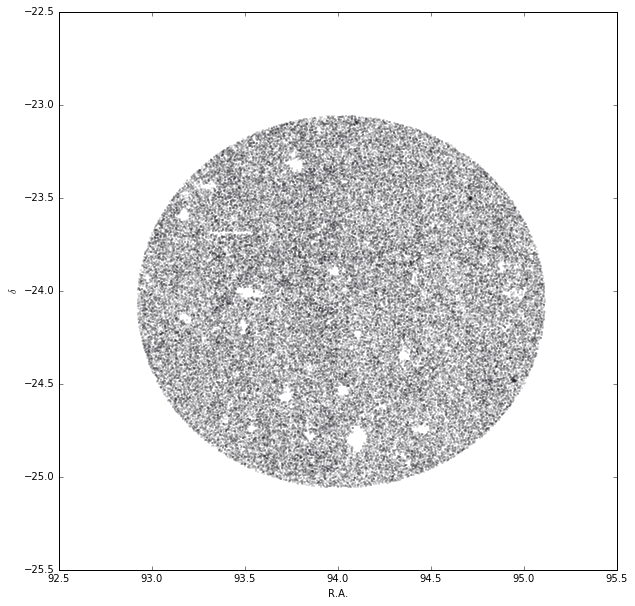

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(field1['l'], field1['b'], marker='.', s=0.1)

ax.set_xlabel("R.A.")
ax.set_ylabel("$\delta$")

Ah, look at those gaps! Interesting... We'll get back to those later.

Plot the color magnitude diagram. Just re-use the function from previous SDSS hands-on session:

In [26]:
def add_cmd(ax, data):
    data = data[(data['g'] > 0) & (data['r'] > 0)]

    g = data['g']
    r = data['r']
    gr = g - r

    ax.scatter(gr, r, marker='.', s = 0.1)

    ax.set_xlim(-1, 2.5)
    ax.set_ylim(15, 22)

    ax.invert_yaxis()

    ax.set_xlabel("g - r")
    ax.set_ylabel("r")

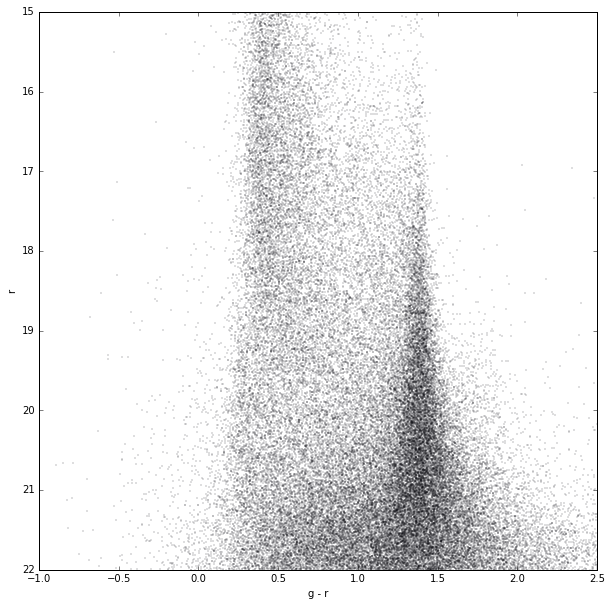

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
add_cmd(ax, field1)

Looks rather similar to what we've had before. Good.

Now grab the monoceros field:

In [28]:
bounds_xy = beam(115.2, 32.7, 1)

rows = db.query('select sdss_id, l, b, g - gExt as g, r - rExt as r, gErr, rErr, flags, flags2 from sdss').fetch(bounds=[(bounds_xy, None)])

field2 = Table(rows.as_ndarray())

 [4 el.]::::::::::::::::::::>  0.70 sec


Plot it:

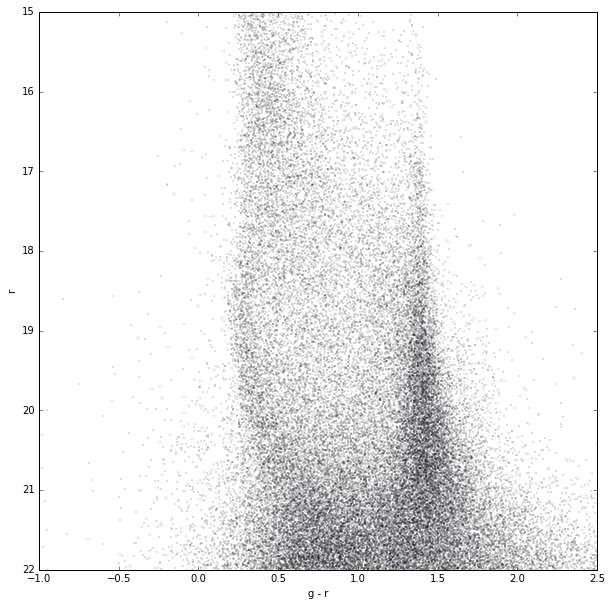

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
add_cmd(ax, field2)

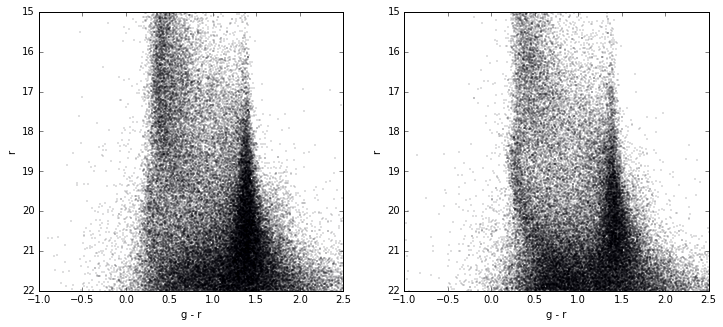

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
add_cmd(ax[0], field1)
add_cmd(ax[1], field2)

Excellent. We can see Monoceros main sequence in the plot on the right, just like we did when we queried the SDSS. However, there seems to be much more noise at faint magnitudes in these data, than there was in SDSS. We'll investigate that further later.

Now, let's convert our full-sky SQL query into the equivalent LSD query. Before we had:

```
select
  s.objid,
  s.l, s.b,
  s.extinction_r as Ar,
  s.dered_g as g, s.dered_r as r,
  s.err_g as gErr, s.err_r as gErr,
  s.flags

from
  Star s

where
  b > 40
  and 0.2 < g - r and g - r < 0.4
  and 21 < r and r < 21.1

into
  mydb.northfiltered
```

To convert this to an LSD query, we'll have to:
  - change the names of columns
  - we'll also add `ra` and `dec`, as we've discovered the last time that those are useful when plotting
  - change the name of the table we're querying
  - modify the `WHERE` clause to remove the geometric constraint (we'll shift that to our `bounds_xy` parameter)
  - modify the `WHERE` clause to use Python bitwise-and (`&`) operator instead of `and`
  - remove the `INTO` clause; there's no need for it here, as we'll stream data back directly into our Python code.

In [31]:
# Note that the coordinate system is now galactic
bounds_xy = beam(0, 90, 50, coordsys="gal")

rows = db.query("""\
SELECT sdss_id, l, b, ra, dec, g - gExt as g, r - rExt as r, gErr, rErr, flags, flags2
FROM sdss
WHERE (0.2 < g - r) & (g - r < 0.4) & (21 < r) & (r < 21.1)
""").fetch(bounds=[(bounds_xy, None)])

sky = Table(rows.as_ndarray())

 [547 el.]::::::::::::::::::::>  14.89 sec


In [32]:
len(sky)

169578

And now, let's plot it

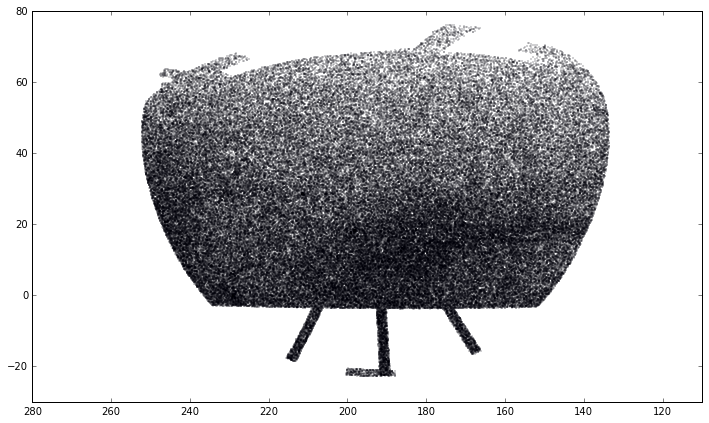

In [33]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_xlim(110, 280)
ax.set_ylim(-30, 80)
ax.invert_xaxis()
ax.scatter(sky['ra'], sky['dec'], s=.2, marker='.')